In [1]:
# Uncomment and run the commands below if imports fail
!pip install jovian --upgrade --quiet
!conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import jovian
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [3]:
# Project name used for jovian.commit
project_name = 'mnist-feedforward'

# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10

In [4]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label: 2


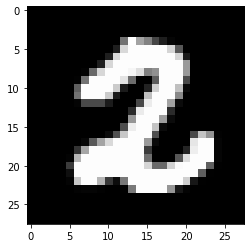

In [5]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

images.shape: torch.Size([128, 1, 28, 28])


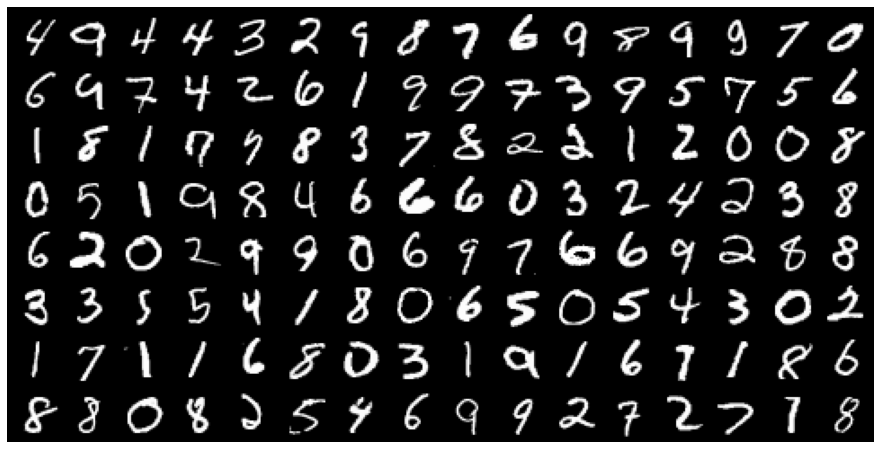

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [9]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [11]:
device = get_default_device()
device

device(type='cpu')

In [12]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [14]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [15]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [16]:
input_size = 28*28
output_size = 10

In [17]:
class MNISTModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 392)
        self.linear2 = nn.Linear(392, 196)
        self.linear3 = nn.Linear(196, 98)
        self.linear4 = nn.Linear(98, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        
        out = self.linear2(out)
        out = F.relu(out)
        
        out = self.linear3(out)
        out = F.relu(out)
        
        out = self.linear4(out)
        
        return out

In [18]:
model = to_device(MNISTModel(), device)

In [19]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.304605484008789, 'val_acc': 0.10947265475988388}]

In [20]:
epochs_list = [50, 25, 10, 5]
learning_rates = [0.1, 0.001, 0.0001, 0.00001]

In [21]:
history += fit(epochs_list[0], learning_rates[0], model, train_loader, val_loader)

Epoch [0], val_loss: 0.3674, val_acc: 0.8888
Epoch [1], val_loss: 0.2593, val_acc: 0.9211
Epoch [2], val_loss: 0.1705, val_acc: 0.9496
Epoch [3], val_loss: 0.1446, val_acc: 0.9567
Epoch [4], val_loss: 0.1194, val_acc: 0.9626
Epoch [5], val_loss: 0.1010, val_acc: 0.9693
Epoch [6], val_loss: 0.1021, val_acc: 0.9697
Epoch [7], val_loss: 0.0919, val_acc: 0.9721
Epoch [8], val_loss: 0.0834, val_acc: 0.9766
Epoch [9], val_loss: 0.0811, val_acc: 0.9771
Epoch [10], val_loss: 0.0745, val_acc: 0.9797
Epoch [11], val_loss: 0.0870, val_acc: 0.9765
Epoch [12], val_loss: 0.0867, val_acc: 0.9771
Epoch [13], val_loss: 0.0765, val_acc: 0.9786
Epoch [14], val_loss: 0.0725, val_acc: 0.9810
Epoch [15], val_loss: 0.0765, val_acc: 0.9798
Epoch [16], val_loss: 0.0759, val_acc: 0.9809
Epoch [17], val_loss: 0.0748, val_acc: 0.9804
Epoch [18], val_loss: 0.0737, val_acc: 0.9811
Epoch [19], val_loss: 0.0775, val_acc: 0.9804
Epoch [20], val_loss: 0.0760, val_acc: 0.9825
Epoch [21], val_loss: 0.0768, val_acc: 0.981

In [22]:
history += fit(epochs_list[1], learning_rates[1], model, train_loader, val_loader)

Epoch [0], val_loss: 0.0929, val_acc: 0.9813
Epoch [1], val_loss: 0.0929, val_acc: 0.9813
Epoch [2], val_loss: 0.0929, val_acc: 0.9813
Epoch [3], val_loss: 0.0928, val_acc: 0.9813
Epoch [4], val_loss: 0.0928, val_acc: 0.9812
Epoch [5], val_loss: 0.0928, val_acc: 0.9812
Epoch [6], val_loss: 0.0928, val_acc: 0.9812
Epoch [7], val_loss: 0.0928, val_acc: 0.9812
Epoch [8], val_loss: 0.0928, val_acc: 0.9814
Epoch [9], val_loss: 0.0928, val_acc: 0.9814
Epoch [10], val_loss: 0.0928, val_acc: 0.9813
Epoch [11], val_loss: 0.0928, val_acc: 0.9813
Epoch [12], val_loss: 0.0928, val_acc: 0.9813
Epoch [13], val_loss: 0.0929, val_acc: 0.9813
Epoch [14], val_loss: 0.0929, val_acc: 0.9813
Epoch [15], val_loss: 0.0929, val_acc: 0.9813
Epoch [16], val_loss: 0.0929, val_acc: 0.9812
Epoch [17], val_loss: 0.0929, val_acc: 0.9812
Epoch [18], val_loss: 0.0929, val_acc: 0.9812
Epoch [19], val_loss: 0.0929, val_acc: 0.9812
Epoch [20], val_loss: 0.0929, val_acc: 0.9812
Epoch [21], val_loss: 0.0929, val_acc: 0.981

In [23]:
history += fit(epochs_list[2], learning_rates[2], model, train_loader, val_loader)

Epoch [0], val_loss: 0.0929, val_acc: 0.9812
Epoch [1], val_loss: 0.0929, val_acc: 0.9812
Epoch [2], val_loss: 0.0929, val_acc: 0.9812
Epoch [3], val_loss: 0.0929, val_acc: 0.9812
Epoch [4], val_loss: 0.0929, val_acc: 0.9812
Epoch [5], val_loss: 0.0929, val_acc: 0.9812
Epoch [6], val_loss: 0.0929, val_acc: 0.9812
Epoch [7], val_loss: 0.0929, val_acc: 0.9812
Epoch [8], val_loss: 0.0929, val_acc: 0.9812
Epoch [9], val_loss: 0.0929, val_acc: 0.9812


In [24]:
history += fit(epochs_list[3], learning_rates[3], model, train_loader, val_loader)

Epoch [0], val_loss: 0.0929, val_acc: 0.9812
Epoch [1], val_loss: 0.0929, val_acc: 0.9812
Epoch [2], val_loss: 0.0929, val_acc: 0.9812
Epoch [3], val_loss: 0.0929, val_acc: 0.9812
Epoch [4], val_loss: 0.0929, val_acc: 0.9812


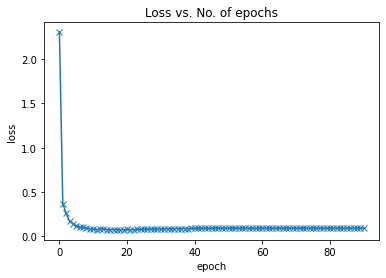

In [25]:
plot_losses(history)

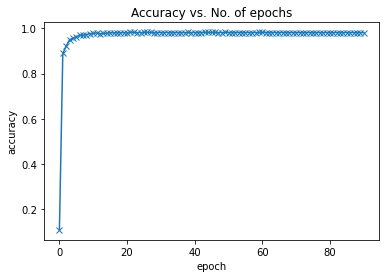

In [26]:
plot_accuracies(history)

In [27]:
final_test_eval = evaluate(model, test_loader)
final_test_eval

{'val_loss': 0.09129379689693451, 'val_acc': 0.98095703125}

In [28]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 3 , Predicted: 3


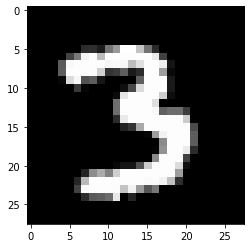

In [31]:
img, label = test_ds[500]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [32]:
incorrect_count = 0

for data in test_ds:
    img, label = data
    print('Label:', label, ', Predicted:', predict_image(img, model))
    if (label != predict_image(img, model)):
        incorrect_count += 1

Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 7 , Predi

Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 6 , Predicted: 0
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 2 , Predicted: 2
Label: 3 , Predi

Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 6 , Predicted: 6
Label: 3 , Predicted: 3
Label: 2 , Predicted: 2
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 7 , Predicted: 7
Label: 9 , Predicted: 9
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 1 , Predi

Label: 0 , Predicted: 0
Label: 9 , Predicted: 5
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 0 , Predicted: 0
Label: 5 , Predicted: 5
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 8 , Predi

Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 3 , Predicted: 7
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 0 , Predi

Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 2 , Predicted: 0
Label: 8 , Predicted: 8
Label: 5 , Predicted: 5
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 3 , Predicted: 7
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 6 , Predicted: 4
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 8 , Predi

Label: 2 , Predicted: 2
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 5 , Predicted: 5
Label: 0 , Predicted: 0
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 0 , Predi

Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 9 , Predicted: 5
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 3 , Predicted: 5
Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 5 , Predi

Label: 0 , Predicted: 0
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 0 , Predi

Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 9 , Predicted: 9
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 7 , Predicted: 8
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 2 , Predicted: 0
Label: 3 , Predicted: 3
Label: 8 , Predicted: 8
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 0 , Predicted: 6
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 3 , Predi

Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 7 , Predicted: 9
Label: 7 , Predicted: 7
Label: 1 , Predicted: 7
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 2 , Predicted: 2
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 6 , Predicted: 6
Label: 1 , Predi

Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 3 , Predicted: 3
Label: 8 , Predicted: 4
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 8 , Predi

Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 2 , Predicted: 2
Label: 7 , Predicted: 1
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 8 , Predicted: 3
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 3 , Predi

Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 2 , Predicted: 2
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 2 , Predi

Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 8 , Predi

Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 6 , Predi

Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 7 , Predicted: 7
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predi

Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 4 , Predicted: 4
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 6 , Predicted: 6
Label: 3 , Predicted: 3
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 9 , Predicted: 9
Label: 0 , Predi

Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 4 , Predi

Label: 7 , Predicted: 7
Label: 6 , Predicted: 6
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 1 , Predicted: 1
Label: 8 , Predicted: 6
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predi

Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 3 , Predicted: 3
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 7 , Predi

Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 3 , Predicted: 3
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 6 , Predi

Label: 5 , Predicted: 5
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 1 , Predicted: 1
Label: 7 , Predicted: 7
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 5 , Predicted: 5
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 7 , Predicted: 7
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 0 , Predi

Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 0 , Predicted: 0
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 7 , Predicted: 7
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 2 , Predicted: 2
Label: 3 , Predi

Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 4 , Predicted: 4
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6


In [33]:
print("Incorrect Predictions by Model:", incorrect_count)

Incorrect Predictions by Model: 195


In [ ]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')
jovian.log_metrics(val_acc = history[-1]['val_acc'], val_loss = history[-1]['val_loss'], incorrect_predictions = incorrect_count)
jovian.log_hyperparams(lr = learning_rates, epochs = epochs_list, batch_size = batch_size)
jovian.commit(project=project_name, outputs=['mnist-feedforward.pth'], environment=None)

[jovian] Metrics logged.
[jovian] Hyperparams logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
